<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
max_trials = 10
epochs = 100

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
!pip install keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
!pip install yfinance
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
#Ensuring the use of gpu tensorflow

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [40]:
#Enter info regarding model

num_inputs=4
look_back = 60
forward_days = 1
num_periods = 20

[*********************100%***********************]  1 of 1 completed


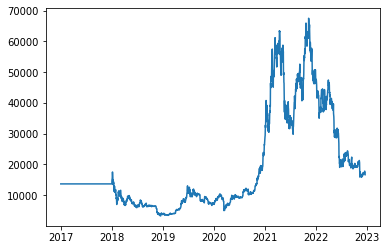

In [41]:
#data

today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2017-01-01', today)

df_A = yf.download("BTC-USD", start="2018-01-01", end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_A)

In [42]:
type(df_A)

pandas.core.series.Series

[*********************100%***********************]  1 of 1 completed


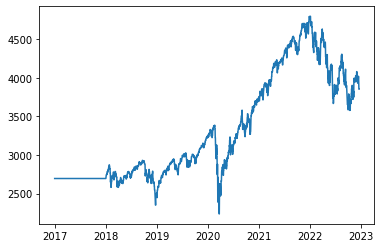

In [43]:
df_B = yf.download("%5EGSPC", start="2018-01-01", end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_B)

[*********************100%***********************]  1 of 1 completed


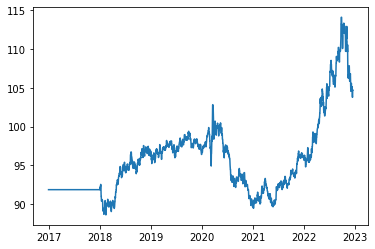

In [44]:
df_C = yf.download("DX-Y.NYB", start="2018-01-01", end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_C)

[*********************100%***********************]  1 of 1 completed


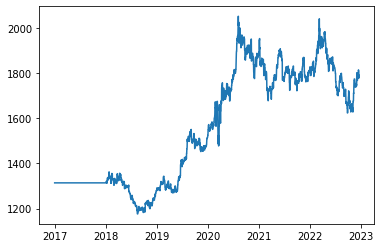

In [45]:
df_D = yf.download("GC=F", start="2018-01-01", end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_D)

[*********************100%***********************]  1 of 1 completed


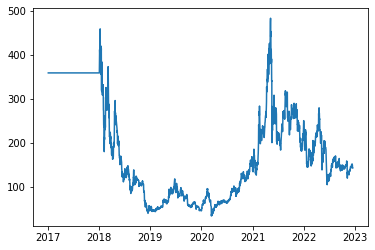

In [46]:
df_E = yf.download("XMR-USD", start="2018-01-01", end=today)["Close"]
df_E = df_E.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_E)

In [47]:
timeseries = pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])

In [48]:
scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"].shift(-1)
timeseries.drop(timeseries.tail(1).index, inplace=True)

array = timeseries.values

timeseries.head()

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2017-01-01,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-02,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-03,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-04,0.161984,0.179125,0.127743,0.157089,0.161984
2017-01-05,0.161984,0.179125,0.127743,0.157089,0.161984


In [49]:
#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division:]
array_train = array[:division]
# split into input and outputs
X_train, Y_train = array_train[:, :-1], array_train[:, -1]
X_test, Y_test = array_test[:, :-1], array_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [50]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model

hypermodel = MyHyperModel(num_classes=1)    

In [ ]:
# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=max_trials,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="models-temp")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=epochs,
             validation_data=(X_validate, Y_validate))

Trial 3 Complete [00h 00m 35s]
val_loss: 0.000409756728913635

Best val_loss So Far: 0.0002069306356133893
Total elapsed time: 00h 02m 00s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
120               |80                |NUM_NEURONS_FirstLayer
0.3               |0.2               |dropout_1
60                |60                |NUM_NEURONS_SecondLayer
0                 |0.1               |dropout_2
0.0001            |0.01              |learning_rate

Epoch 1/100
54/54 [==============================] - 5s 30ms/step - loss: 0.1096 - val_loss: 0.1106
Epoch 2/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0869 - val_loss: 0.0850
Epoch 3/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0638 - val_loss: 0.0593
Epoch 4/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0390
Epoch 5/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0289
Epoch 6/100
5

In [ ]:
#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

In [ ]:
#Evaluate it on the validation test

print("Evalutation of best performing model:")
print(best_model.evaluate(X_validate, Y_validate))

In [ ]:
#Get summary

random_tuner.results_summary()

In [ ]:
#Saving the model

file_name = 'LSTM_BTC_tuned_multi.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

In [ ]:
#Predict 

yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scl.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scl.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()